<a href="https://colab.research.google.com/github/nastaranmarzban/BGAT-and-GAT-Jupyter-notebook/blob/main/GAT_5classes_150nodes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount to gdrive to read data, adjacency matrix, p_link and labels.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

# Load data which are processed in preprocessing_data_4classdes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/5classes_150.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-1.1996, -0.5363, -1.0551,  ...,  1.0784, -0.1099,  0.6258],
         [ 1.9717,  1.5424,  1.0104,  ..., -0.6536,  2.3499, -0.1438],
         [-0.3870,  0.3711, -1.0519,  ..., -0.6554,  2.1013, -0.8379],
         ...,
         [-1.4236, -1.3652, -1.1248,  ..., -1.0004,  0.0174,  1.6165],
         [-0.5597, -2.0122,  0.3641,  ...,  0.2956, -0.0478, -0.5333],
         [ 0.5681, -0.7714,  0.7749,  ..., -0.5489, -1.6281,  1.2040]]),
 'edge_index': tensor([[  0,   0,   0,  ..., 149, 149, 149],
         [ 21,  57,  97,  ..., 109, 128, 141]]),
 'y': tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
         1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
         3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
         0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
         3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
         2, 1, 2, 4, 1, 0, 1, 3, 

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 150
Number of features: 500
Number of classes: 5
Number of edges: 954
Average node degree: 6.36
Number of training nodes: 120
Number of testing nodes: 15
Training node label rate: 0.80


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/5classes_150.sim/p_link.pt"
p_link = torch.load(path)
print(p_link)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.1500, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.7700, 0.0000],
        ...,
        [0.1500, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7700,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])
torch.Size([150, 150])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 42.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
import torch_geometric
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

# Creating message passing network.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 500, out_channels = 8)
        self.conv2 =  GATConv(8, 8)
        self.conv3 =  GATConv(8, 5)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        #h = F.log_softmax(h)
        return h

model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): GATConv(500, 8, heads=1)
  (conv2): GATConv(8, 8, heads=1)
  (conv3): GATConv(8, 5, heads=1)
)
tensor([[-2.6028e-01, -7.2623e-01, -2.6368e-02,  1.0084e-01, -1.8341e-01],
        [-6.9468e-02, -4.0800e-01, -2.9276e-02, -6.1199e-02, -6.0022e-02],
        [-4.2563e-01,  4.5746e-01,  3.6245e-01, -3.4632e-02,  5.3340e-01],
        [-3.7816e-01,  9.4550e-02,  3.3227e-01,  3.2401e-01, -6.9229e-02],
        [ 1.4746e-01,  5.1817e-01, -2.9699e-01, -5.9142e-02,  3.8256e-01],
        [-1.3873e-01, -5.1156e-01, -2.9132e-02, -1.0787e-01, -3.7628e-02],
        [-2.4163e-01, -1.2076e-01,  7.9663e-02,  1.7744e-02,  9.8383e-02],
        [-7.8013e-01, -9.0177e-01,  1.4718e-02, -3.4354e-01,  3.2712e-01],
        [-6.7158e-02,  3.7308e-01,  1.3804e-01,  2.5611e-01,  4.3410e-05],
        [ 3.5778e-01,  3.7840e-01,  1.3207e-02,  3.4710e-01, -3.2119e-01],
        [-9.5043e-02,  3.6620e-01,  1.9026e-01,  3.1614e-01, -3.8612e-02],
        [-3.0528e-01, -3.3285e-01,  4.1886e-01, -2.4943e-01, 

# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",5)).set(title = "Second scenario data T-SNE projection before training (GAT)")

Embedding shape: [150, 5]


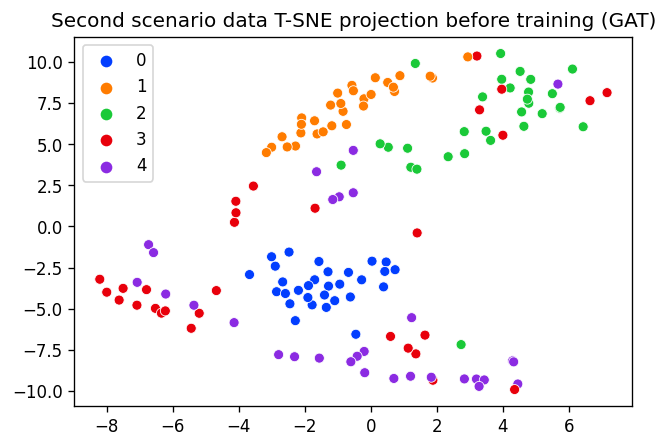

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model.

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss


In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 26):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())






  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

1 Train Loss: 1.715 | val Loss: 1.674
2 Train Loss: 1.642 | val Loss: 1.599
3 Train Loss: 1.577 | val Loss: 1.532
4 Train Loss: 1.522 | val Loss: 1.473
5 Train Loss: 1.474 | val Loss: 1.418
6 Train Loss: 1.430 | val Loss: 1.367
7 Train Loss: 1.391 | val Loss: 1.326
8 Train Loss: 1.357 | val Loss: 1.293
9 Train Loss: 1.327 | val Loss: 1.267
10 Train Loss: 1.302 | val Loss: 1.247
11 Train Loss: 1.280 | val Loss: 1.229
12 Train Loss: 1.259 | val Loss: 1.213
13 Train Loss: 1.239 | val Loss: 1.198
14 Train Loss: 1.219 | val Loss: 1.183
15 Train Loss: 1.201 | val Loss: 1.169
16 Train Loss: 1.183 | val Loss: 1.155
17 Train Loss: 1.165 | val Loss: 1.141
18 Train Loss: 1.147 | val Loss: 1.127
19 Train Loss: 1.131 | val Loss: 1.115
20 Train Loss: 1.115 | val Loss: 1.103
21 Train Loss: 1.100 | val Loss: 1.092
22 Train Loss: 1.086 | val Loss: 1.083
23 Train Loss: 1.073 | val Loss: 1.074
24 Train Loss: 1.060 | val Loss: 1.066
25 Train Loss: 1.048 | val Loss: 1.059


# Visualize train loss and val loss.


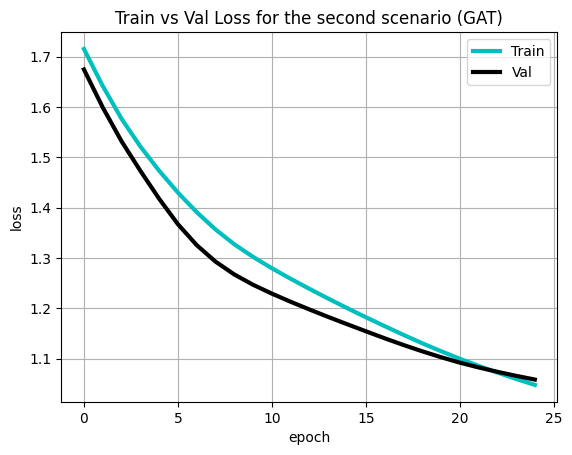

In [ ]:
plt.plot(train_loss_, "c", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the second scenario (GAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim = 1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc


In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 86.67


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(x = z[:, 0], y = z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",5)).set(title = "Second scenario data T-SNE projection after training (GAT)")

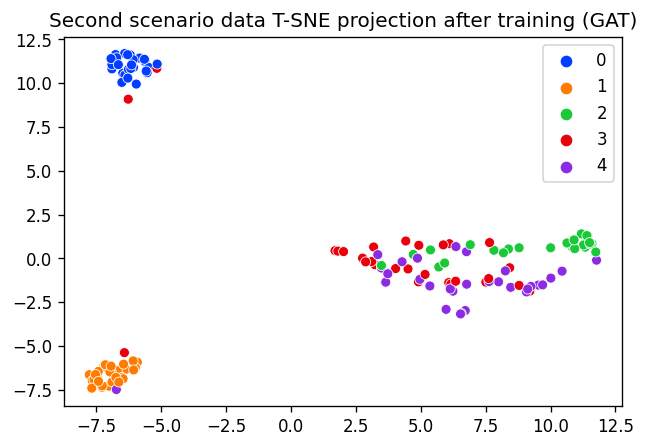

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred_t = out.argmax(dim=1)
pred_t

tensor([2, 1, 2, 4, 4, 1, 0, 4, 4, 4, 4, 0, 1, 0, 2, 4, 2, 1, 4, 0, 0, 1, 2, 1,
        1, 2, 0, 0, 2, 4, 2, 1, 0, 0, 0, 4, 0, 0, 1, 1, 4, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 4, 3, 3, 2, 4, 4, 2, 2, 2, 4, 4, 3, 2, 1, 4, 3, 0, 4, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 1, 1, 3, 0, 1, 2, 2, 2, 2, 4, 0,
        0, 2, 1, 4, 0, 2, 1, 2, 0, 0, 4, 2, 0, 0, 0, 4, 1, 3, 0, 1, 1, 1, 1, 3,
        2, 1, 2, 1, 1, 0, 1, 2, 0, 2, 1, 3, 2, 2, 2, 4, 2, 4, 2, 2, 0, 0, 2, 1,
        1, 1, 2, 2, 4, 0])

In [ ]:
Data["y"]

tensor([2, 1, 3, 4, 4, 1, 0, 4, 4, 2, 4, 3, 1, 0, 2, 4, 2, 1, 3, 0, 0, 1, 2, 1,
        1, 2, 3, 0, 2, 4, 2, 1, 0, 0, 0, 3, 0, 0, 1, 1, 3, 0, 0, 1, 1, 4, 4, 1,
        3, 4, 0, 4, 3, 3, 3, 3, 4, 2, 2, 2, 4, 4, 3, 2, 1, 3, 3, 0, 3, 0, 4, 4,
        0, 0, 1, 2, 4, 1, 0, 4, 1, 3, 2, 0, 0, 4, 1, 3, 0, 4, 2, 2, 3, 2, 4, 3,
        3, 2, 1, 4, 4, 2, 4, 2, 0, 0, 4, 2, 3, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3,
        2, 1, 2, 4, 1, 0, 1, 3, 0, 2, 1, 3, 3, 2, 2, 4, 3, 4, 2, 3, 0, 0, 2, 3,
        1, 1, 2, 2, 4, 0])

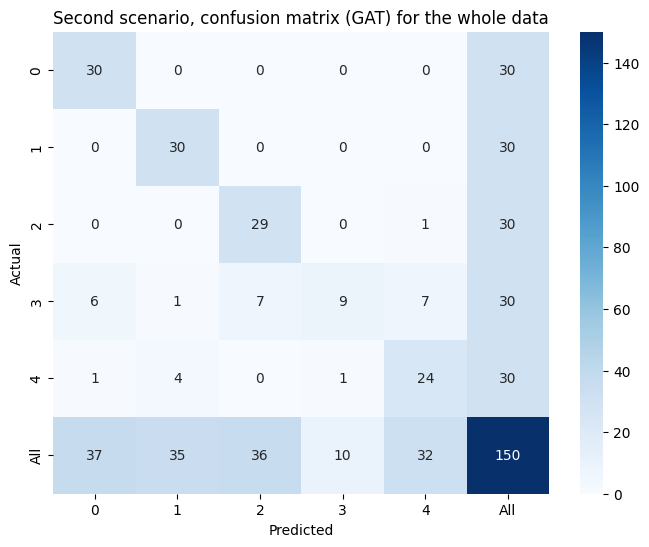

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(Data['y'], pred_t, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (GAT) for the whole data')
plt.show()

In [ ]:
pred = pred_t[Data["test_mask"]]

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted':pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,1,1
1,2,2
2,2,2
3,3,4
4,4,4
5,0,0
6,2,2
7,4,4
8,0,0
9,4,4


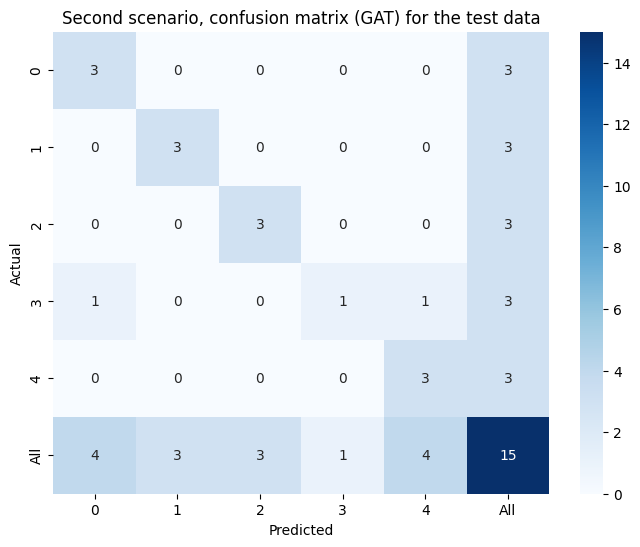

In [ ]:
import seaborn as sn
confusion_matrix = pd.crosstab(act, pred, rownames=['Actual'], colnames = ['Predicted'], margins = True)
plt.figure(figsize=(8, 6))
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues", fmt='g')
plt.title('Second scenario, confusion matrix (GAT) for the test data')
plt.show()